investigating the SuStaIn mixture model

We need to find a distribution of normal vs abnormal 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn.model_selection
import pandas as pd
import pylab
import sys
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from pySuStaIn import ZscoreSustain, MixtureSustain
import dill, multiprocess, pathos
import mrmr

print(pd.__version__)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.3.0


In [3]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'huw_whole_df.csv'), index_col = 0)

dx_map = {
    0: 0,
    1 : 1,
    2 : 2,
    3 : 2,
}


df['DX_bl'] = df['DX_bl'].map(dx_map)

df['DX_bl'].value_counts()

df

,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
1,100_S_5280,101.20,10.08,731.8,2015-09-29,2013-09-17,2,2,67.5,0,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
2,027_S_5277,324.80,34.39,780.3,2015-08-31,2013-08-28,2,2,71.8,1,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
3,135_S_5275,490.40,53.18,832.7,2014-02-25,2013-08-27,0,0,78.0,1,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
4,135_S_5269,108.20,10.55,590.4,2015-09-01,2013-08-20,2,2,64.9,0,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
5,007_S_5265,247.10,24.78,466.1,2015-08-25,2013-08-12,2,2,75.1,1,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,127_S_5266,279.90,24.28,1700.0,2015-08-06,2013-08-15,2,2,65.9,0,...,0.003873,0.012135,0.034131,0.018864,0.008398,0.011478,0.009674,0.007555,0.000818,0.000764
543,053_S_5272,305.00,25.05,1700.0,2015-09-15,2013-09-04,2,2,69.9,1,...,0.003308,0.010313,0.029413,0.016943,0.008936,0.011930,0.008579,0.006243,0.000678,0.000581
544,053_S_5287,268.40,26.11,1700.0,2015-09-30,2013-09-18,2,2,78.9,1,...,0.003723,0.011469,0.026939,0.015693,0.008374,0.011329,0.008016,0.006976,0.000753,0.000723
545,027_S_5288,300.10,26.59,1700.0,2015-09-24,2013-09-25,2,2,81.9,1,...,0.003486,0.011536,0.031103,0.017387,0.008620,0.010525,0.007063,0.005713,0.000815,0.000768


In [6]:
suvr_col = [col for col in df.columns if col.startswith('SUVr')]
suvr_cols = [col for col in suvr_col if not col.startswith('SUVr_Thal')]
csf_cols = ['TAU_bl', 'PTAU_bl']

suvr_cols

['SUVr_ACC_pre_L.nii',
 'SUVr_ACC_pre_R.nii',
 'SUVr_ACC_sub_L.nii',
 'SUVr_ACC_sub_R.nii',
 'SUVr_ACC_sup_L.nii',
 'SUVr_ACC_sup_R.nii',
 'SUVr_Amygdala_L.nii',
 'SUVr_Amygdala_R.nii',
 'SUVr_Angular_L.nii',
 'SUVr_Angular_R.nii',
 'SUVr_Calcarine_L.nii',
 'SUVr_Calcarine_R.nii',
 'SUVr_Caudate_L.nii',
 'SUVr_Caudate_R.nii',
 'SUVr_Cerebellum_3_L.nii',
 'SUVr_Cerebellum_3_R.nii',
 'SUVr_Cerebellum_4_5_L.nii',
 'SUVr_Cerebellum_4_5_R.nii',
 'SUVr_Cerebellum_6_L.nii',
 'SUVr_Cerebellum_6_R.nii',
 'SUVr_Cerebellum_7b_L.nii',
 'SUVr_Cerebellum_7b_R.nii',
 'SUVr_Cerebellum_8_L.nii',
 'SUVr_Cerebellum_8_R.nii',
 'SUVr_Cerebellum_9_L.nii',
 'SUVr_Cerebellum_9_R.nii',
 'SUVr_Cerebellum_10_L.nii',
 'SUVr_Cerebellum_10_R.nii',
 'SUVr_Cerebellum_Crus1_L.nii',
 'SUVr_Cerebellum_Crus1_R.nii',
 'SUVr_Cerebellum_Crus2_L.nii',
 'SUVr_Cerebellum_Crus2_R.nii',
 'SUVr_Cingulate_Mid_L.nii',
 'SUVr_Cingulate_Mid_R.nii',
 'SUVr_Cingulate_Post_L.nii',
 'SUVr_Cingulate_Post_R.nii',
 'SUVr_Cuneus_L.nii',
 'SU

In [12]:
from sklearn.mixture import GaussianMixture

In [84]:
test = df[csf_cols[0]].values.reshape(-1, 1)

In [85]:
test

array([[101.2 ],
       [324.8 ],
       [490.4 ],
       [108.2 ],
       [247.1 ],
       [455.6 ],
       [208.2 ],
       [275.2 ],
       [393.8 ],
       [238.  ],
       [708.  ],
       [161.1 ],
       [162.2 ],
       [302.5 ],
       [356.5 ],
       [427.3 ],
       [113.4 ],
       [320.7 ],
       [492.1 ],
       [276.1 ],
       [343.3 ],
       [176.4 ],
       [380.5 ],
       [440.2 ],
       [209.4 ],
       [111.3 ],
       [155.1 ],
       [145.  ],
       [151.  ],
       [240.  ],
       [119.7 ],
       [379.  ],
       [448.3 ],
       [236.5 ],
       [215.8 ],
       [194.6 ],
       [220.9 ],
       [292.9 ],
       [627.9 ],
       [250.1 ],
       [161.4 ],
       [175.8 ],
       [190.6 ],
       [322.4 ],
       [106.7 ],
       [174.8 ],
       [139.7 ],
       [230.4 ],
       [512.3 ],
       [752.7 ],
       [150.7 ],
       [290.6 ],
       [207.2 ],
       [436.4 ],
       [270.8 ],
       [146.6 ],
       [204.5 ],
       [254.9 ],
       [319.1 

In [86]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(test)

,n_components,2
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,0


In [87]:
probs = gmm.predict_proba(test)


In [88]:
means = gmm.means_.flatten()
normal_idx = np.argmin(means)
abnormal_idx = 1 - normal_idx

In [89]:
l_no = probs[:, normal_idx]
l_yes = probs[:, abnormal_idx]

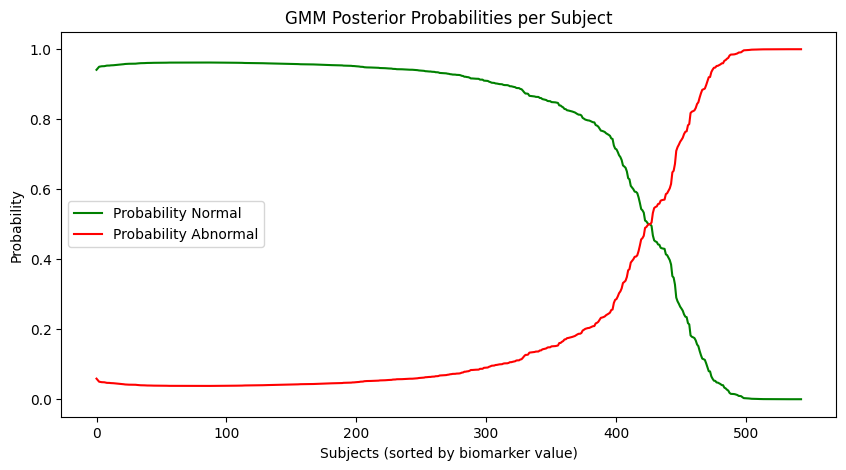

In [90]:
sorted_indices = np.argsort(test.flatten())
sorted_prob_normal = l_no[sorted_indices]
sorted_prob_abnormal = l_yes[sorted_indices]

plt.figure(figsize=(10,5))
plt.plot(sorted_prob_normal, label='Probability Normal', color='green')
plt.plot(sorted_prob_abnormal, label='Probability Abnormal', color='red')
plt.xlabel('Subjects (sorted by biomarker value)')
plt.ylabel('Probability')
plt.title('GMM Posterior Probabilities per Subject')
plt.legend()
plt.show()

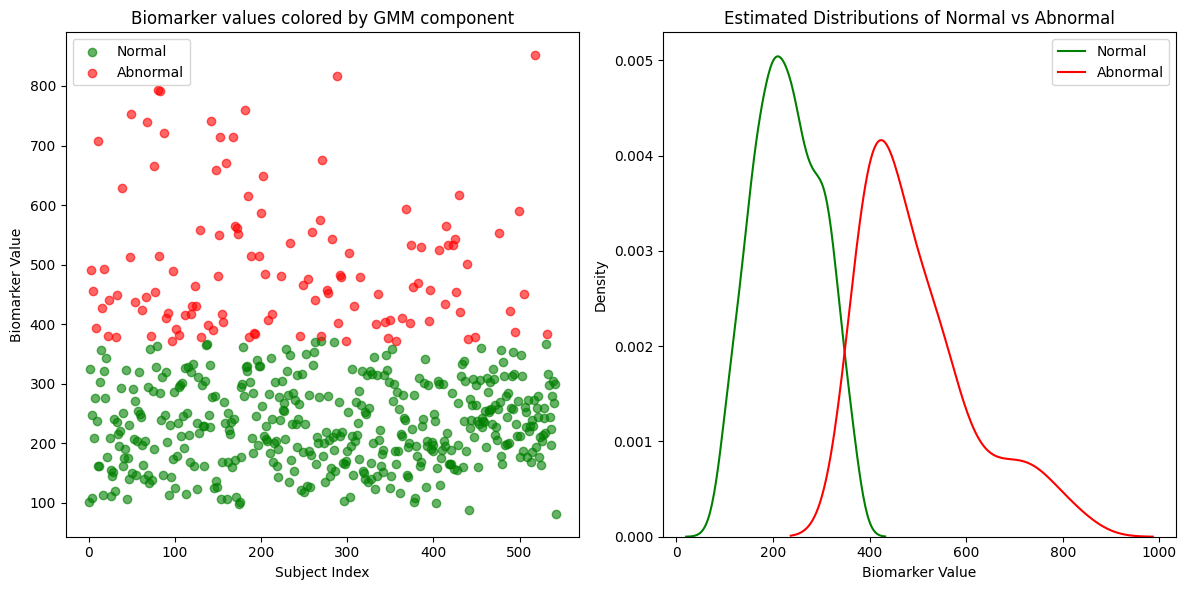

In [ ]:
values = test.flatten()

component_labels = np.argmax(probs, axis=1)

normal_mask = (component_labels == normal_idx)
abnormal_mask = (component_labels == abnormal_idx)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(np.where(normal_mask), values[normal_mask], color='green', alpha=0.6, label='Normal')
plt.scatter(np.where(abnormal_mask), values[abnormal_mask], color='red', alpha=0.6, label='Abnormal')
plt.xlabel('Subject Index')
plt.ylabel('Biomarker Value')
plt.title('Biomarker values colored by GMM component')
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(values[normal_mask], color='green', label='Normal')
sns.kdeplot(values[abnormal_mask], color='red', label='Abnormal')
plt.xlabel('Biomarker Value')
plt.ylabel('Density')
plt.title('Estimated Distributions of Normal vs Abnormal')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
features = mrmr.mrmr_regression(df[suvr_col], y=df['DX_bl'], K=10)

100%|██████████| 10/10 [00:00<00:00, 35.76it/s]


In [13]:

X = df[features + csf_cols]

L_yes = pd.DataFrame(index=X.index, columns=X.columns)
L_no = pd.DataFrame(index=X.index, columns=X.columns)

for biomarker in X.columns:
    values = X[biomarker].values.reshape(-1, 1)

    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
    gmm.fit(values)

    probs = gmm.predict_proba(values)

    means = gmm.means_.flatten()
    abnormal_idx = np.argmax(means) 
    normal_idx = np.argmin(means)


    L_no[biomarker] = probs[:, normal_idx]
    L_yes[biomarker] = probs[:, abnormal_idx]

In [14]:
L_yes = L_yes.to_numpy()

In [15]:
L_no = L_no.to_numpy()

In [34]:
N = len(X.columns)

# SuStaInLabels = suvr_cols[:3]
SuStaInLabels = features + csf_cols

In [29]:
N_startpoints = 10
N_S_max = 3
N_iterations_MCMC = int(1e4)
output_folder = os.path.join(os.getcwd(), 'Mixture') # we change this for each of the different tests
dataset_name = '10feats'

# Initiate the SuStaIn object
sustain_input = MixtureSustain(
                              L_yes,
                              L_no,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

In [30]:
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [35]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Found pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\Mixture\pickle_files\10feats_subtype0.pickle. Using pickled variables for 0 subtype.


ValueError: could not broadcast input array from shape (543,11) into shape (543,21)

Loading pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\Mixture/pickle_files/10feats_subtype2.pickle


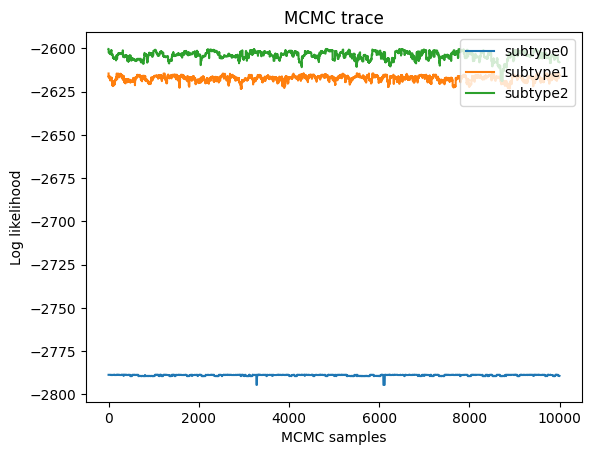

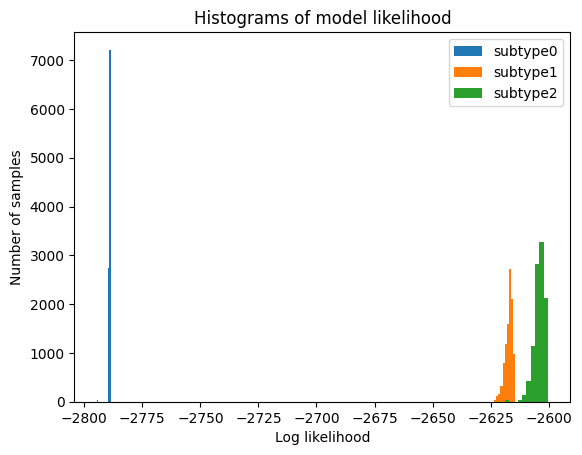

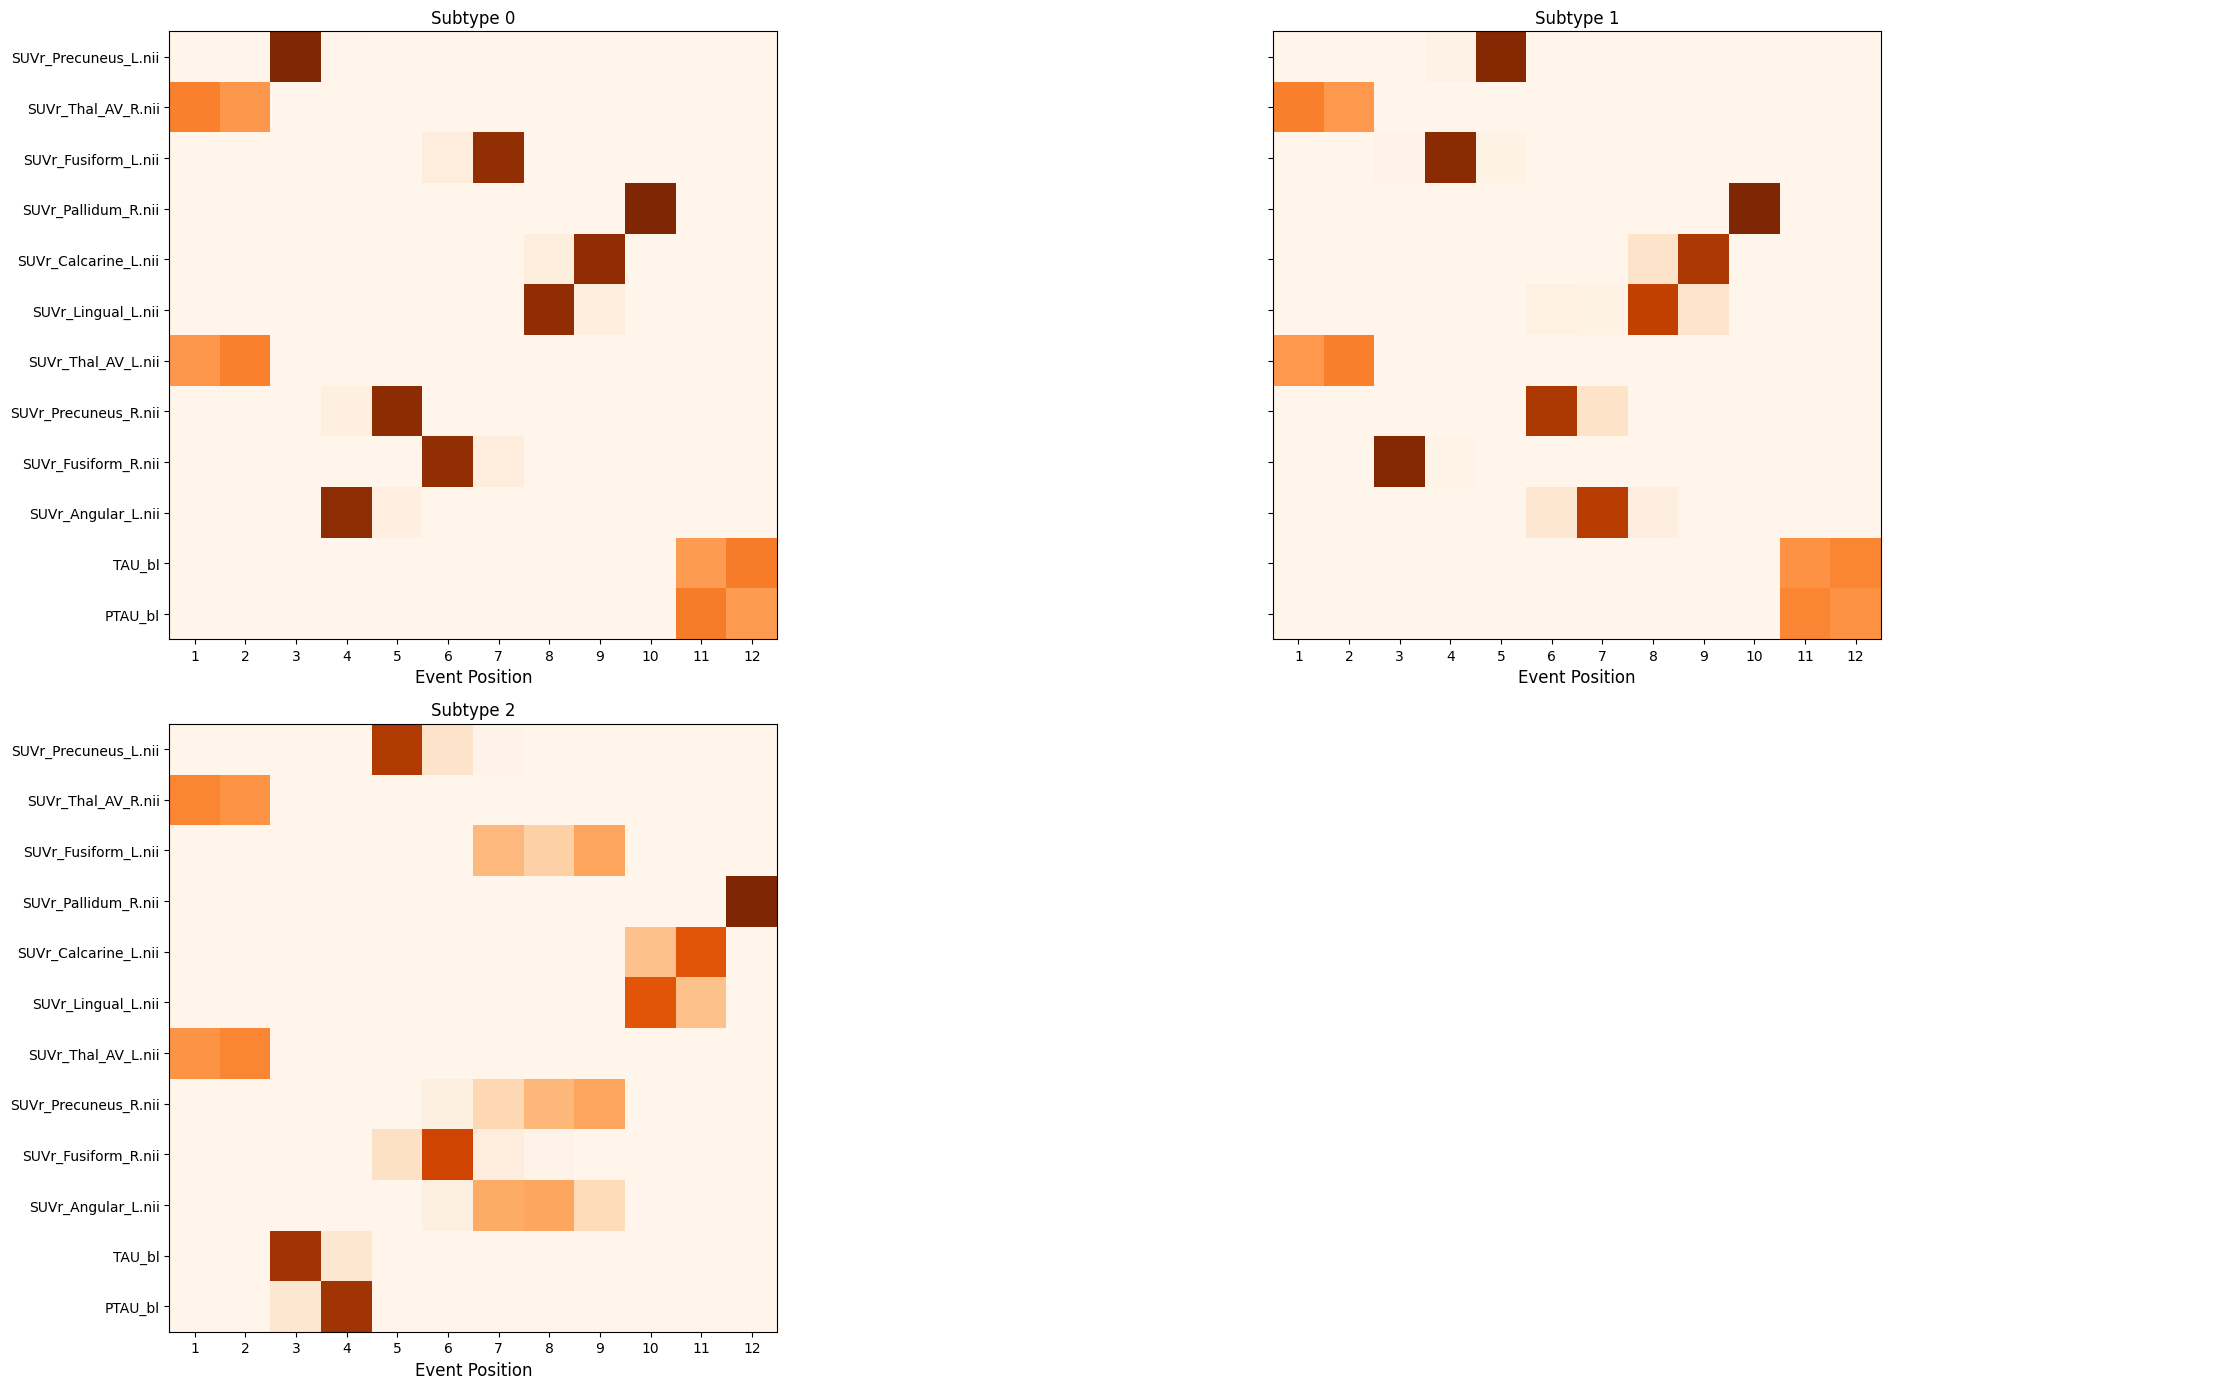

In [36]:



for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pd.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')
    
s = 2 # 1 split = 2 subtypes

M = len(df) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
print("Loading pickle file:", pickle_filename_s)
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=MixtureSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M, figsize = (24,14), biomarker_labels=SuStaInLabels, subtype_titles=['Subtype 0', 'Subtype 1', 'Subtype 2'])

In [24]:
zdata = df.copy()

s = 2
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
print("Loading pickle file:", pickle_filename_s)
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

Loading pickle file: c:\Users\huw\OneDrive\Documents\Research_Internship\adni-ml\Mixture/pickle_files/20suvr_2csf_no_thalamus_subtype2.pickle


,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0,prob_S1
1,100_S_5280,101.2,10.08,731.8,2015-09-29,2013-09-17,2,2,67.5,0,...,0.008881,0.006231,0.000712,0.000659,0.0,0.564154,0.0,0.201192,0.564154,0.227809
2,027_S_5277,324.8,34.39,780.3,2015-08-31,2013-08-28,2,2,71.8,1,...,0.008033,0.006029,0.000770,0.000699,0.0,0.880765,17.0,0.238963,0.880765,0.044948
3,135_S_5275,490.4,53.18,832.7,2014-02-25,2013-08-27,0,0,78.0,1,...,0.007799,0.005730,0.000804,0.000760,1.0,0.513429,19.0,0.144335,0.311247,0.513429
4,135_S_5269,108.2,10.55,590.4,2015-09-01,2013-08-20,2,2,64.9,0,...,0.009789,0.006613,0.000748,0.000675,0.0,0.590087,1.0,0.180034,0.590087,0.202517
5,007_S_5265,247.1,24.78,466.1,2015-08-25,2013-08-12,2,2,75.1,1,...,0.008533,0.005170,0.000675,0.000675,0.0,0.572498,0.0,0.245346,0.572498,0.222148


In [25]:
zdata.ml_subtype.value_counts()


ml_subtype
0.0    424
1.0     74
2.0     45
Name: count, dtype: int64

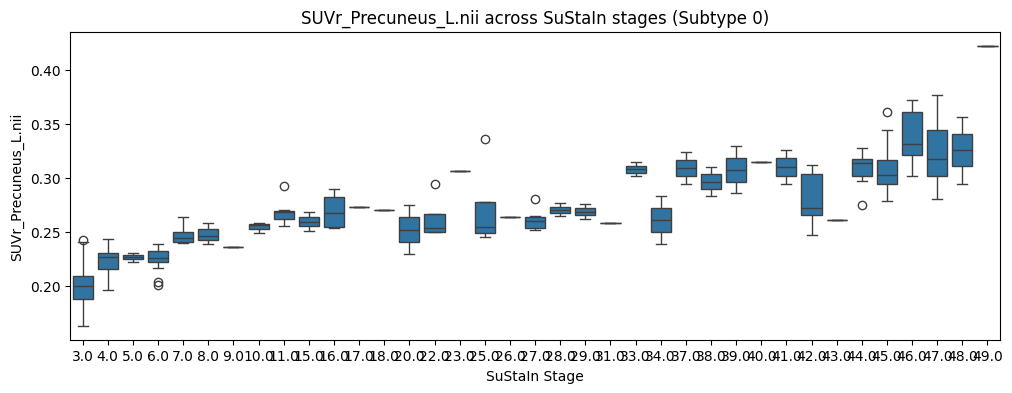

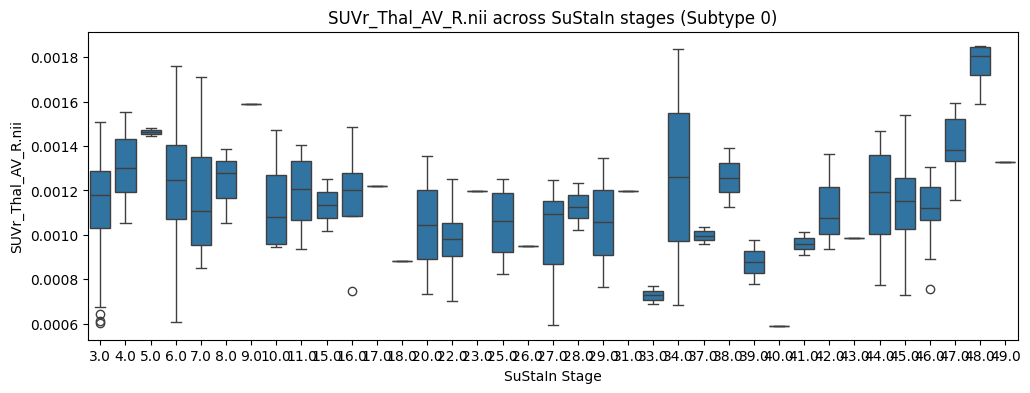

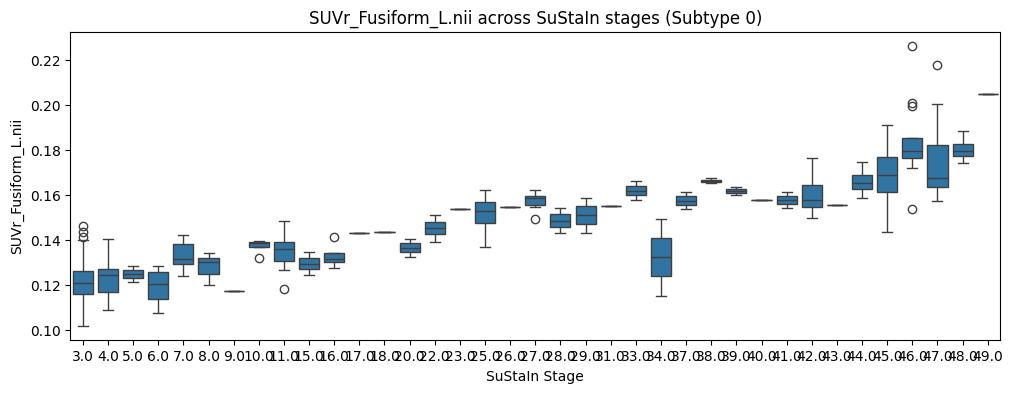

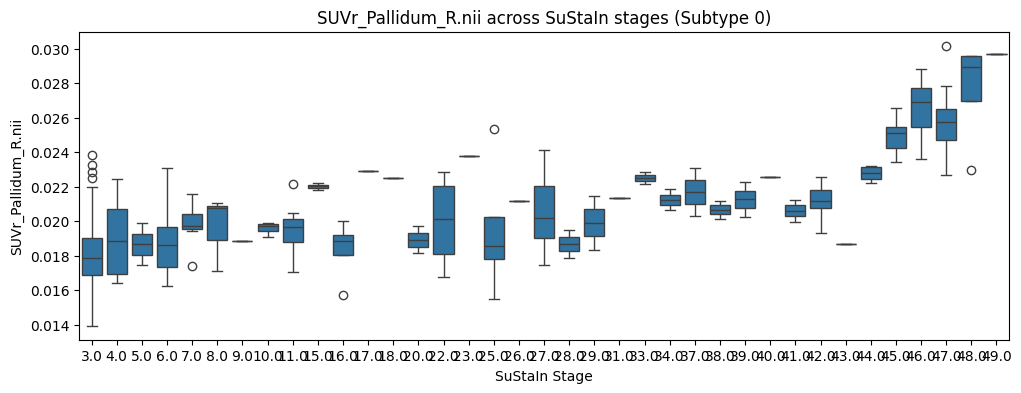

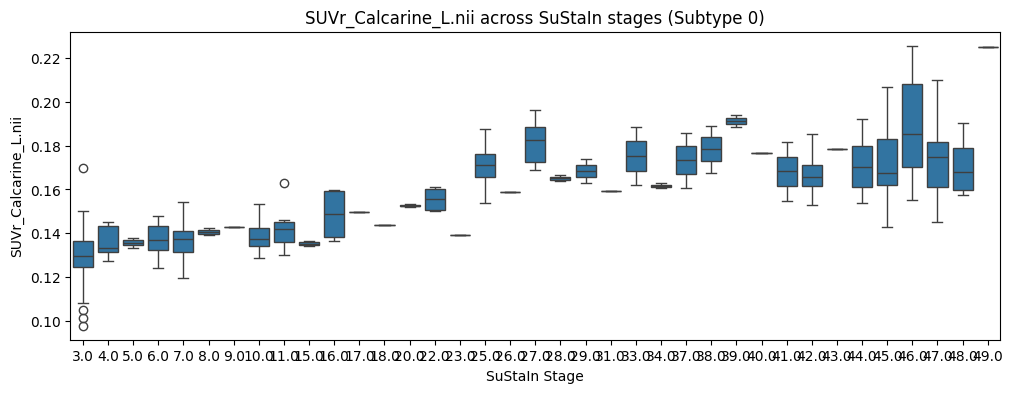

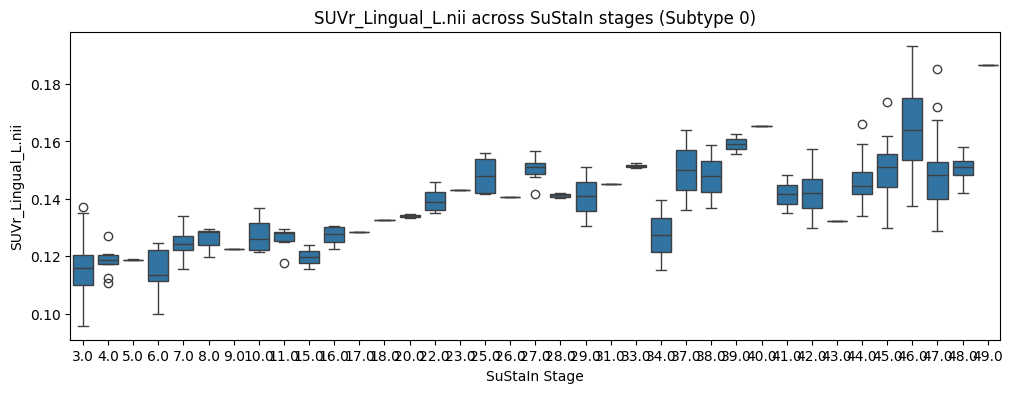

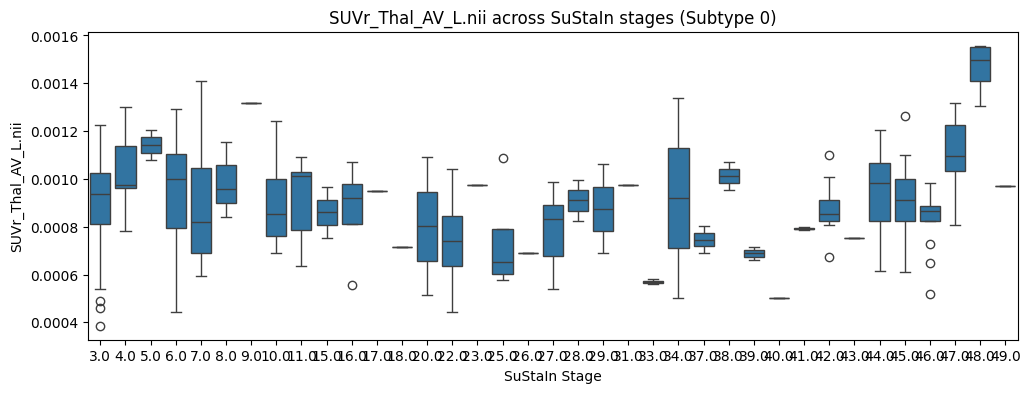

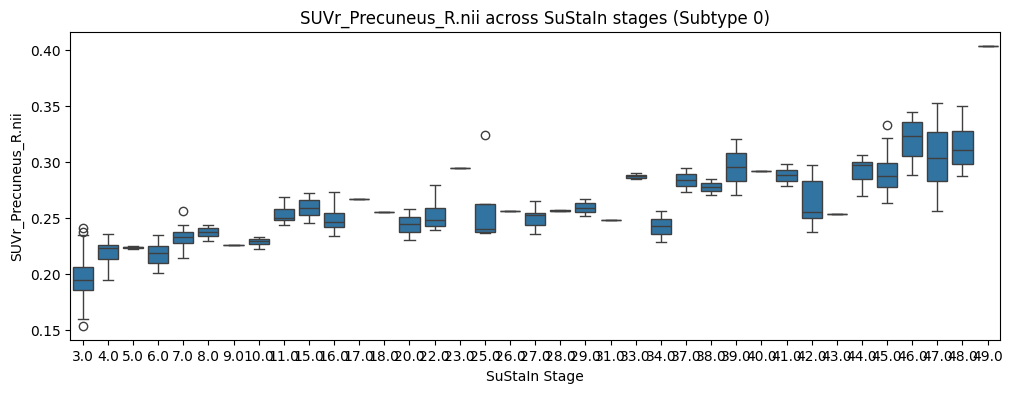

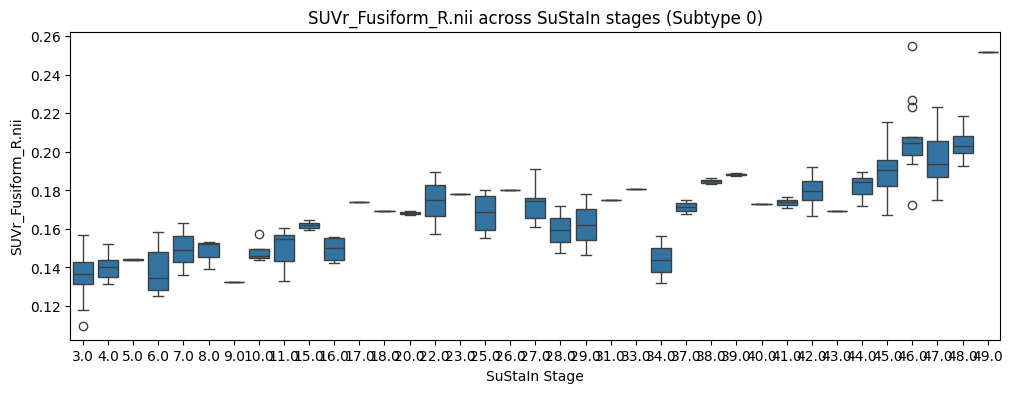

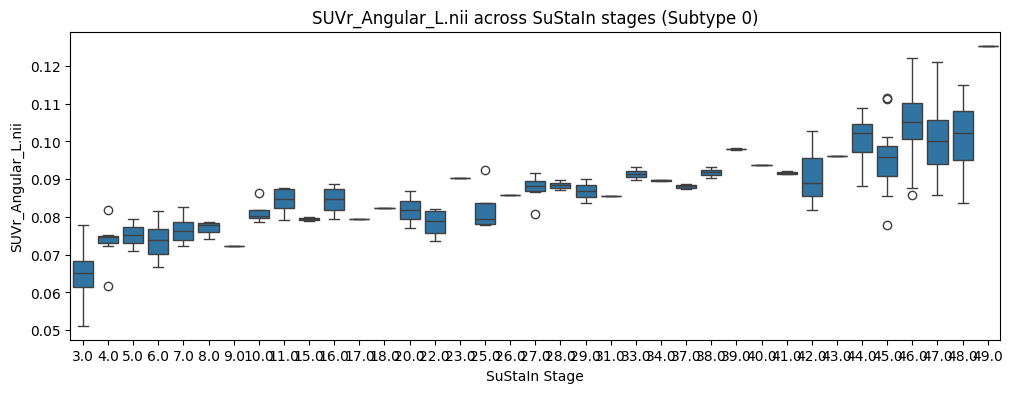

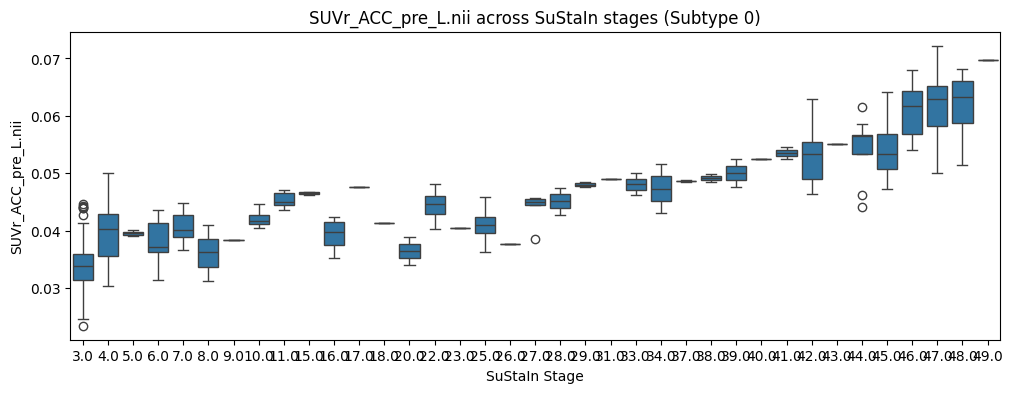

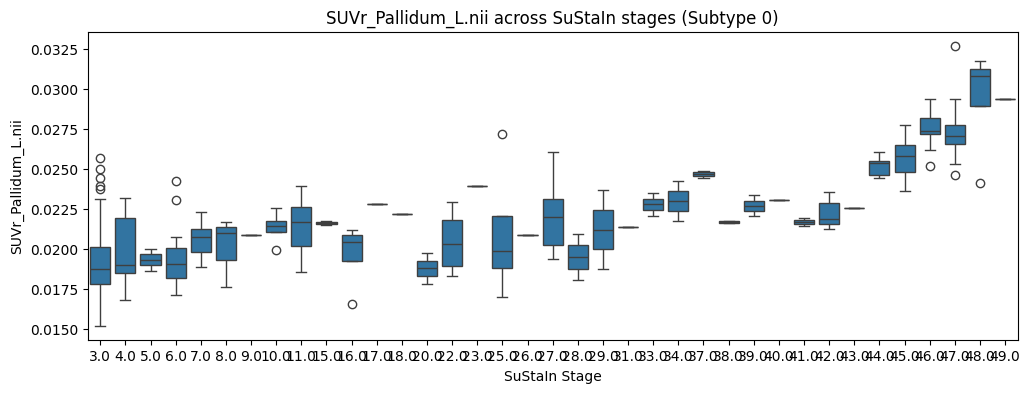

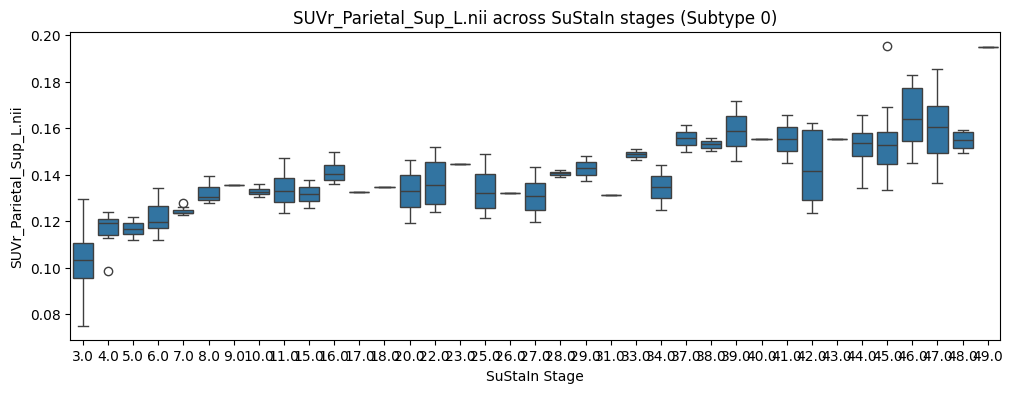

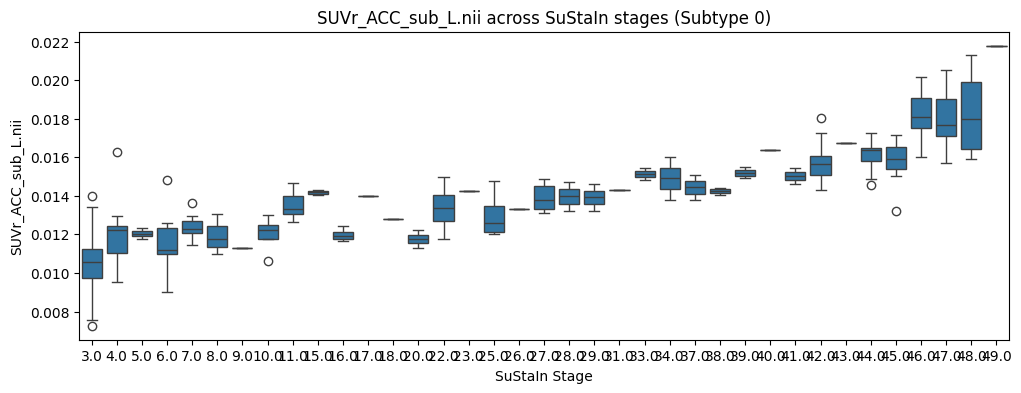

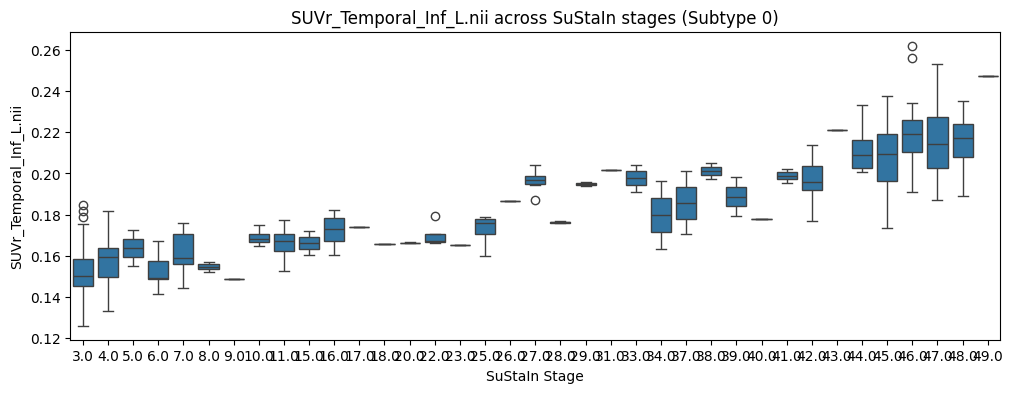

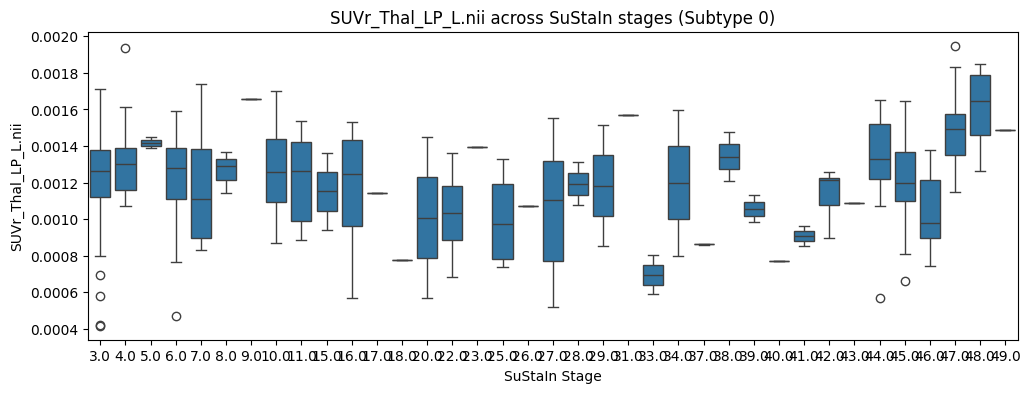

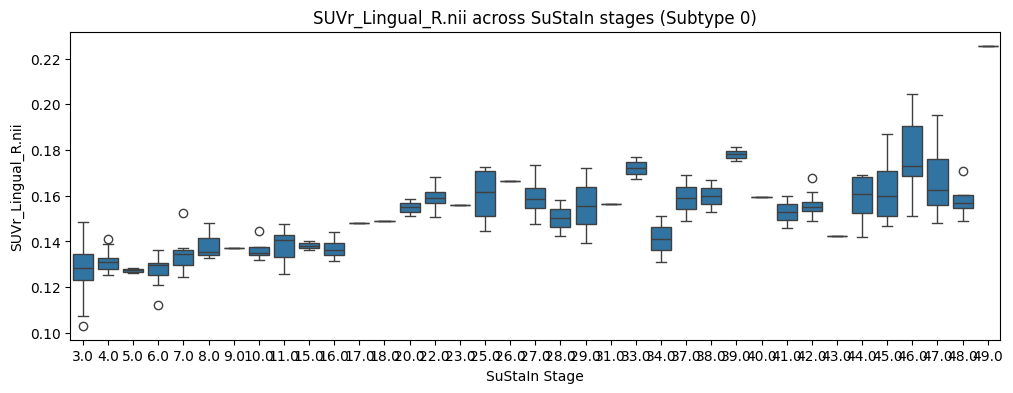

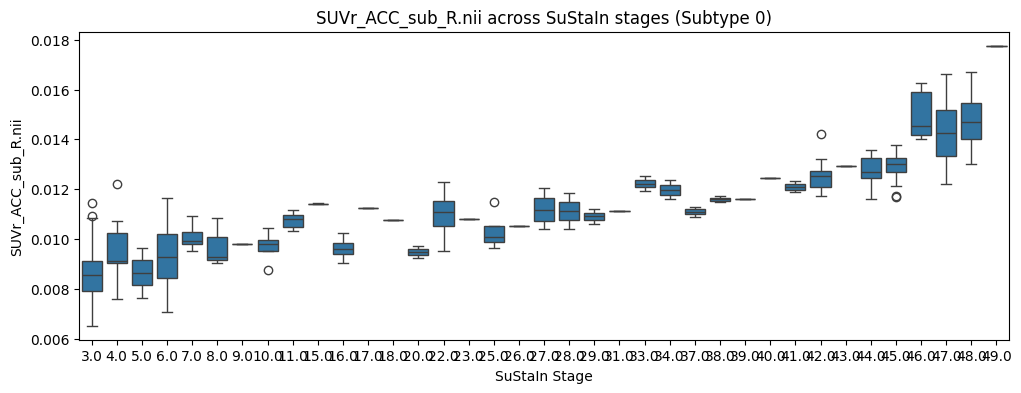

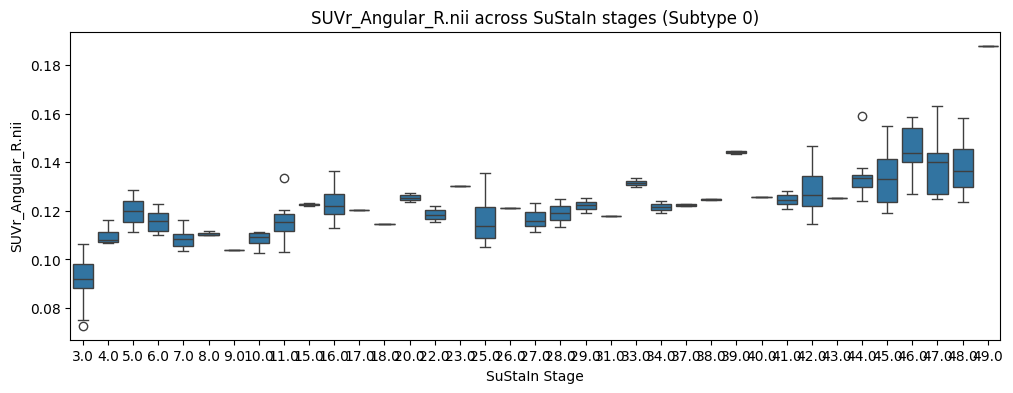

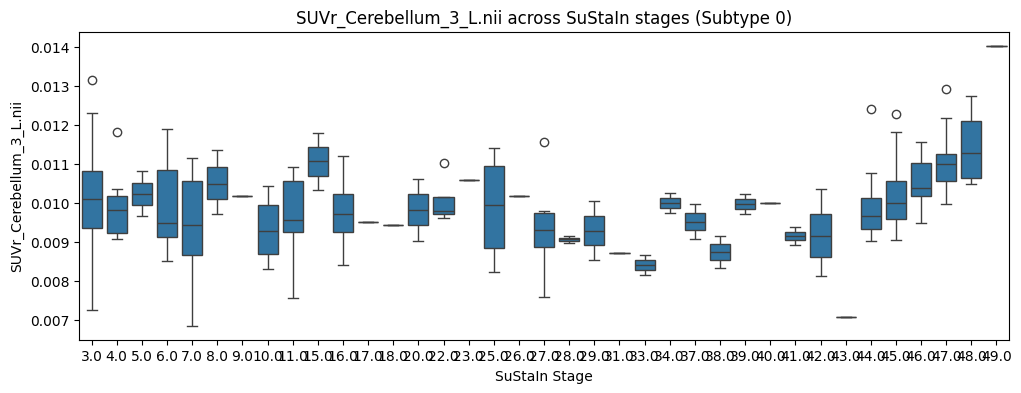

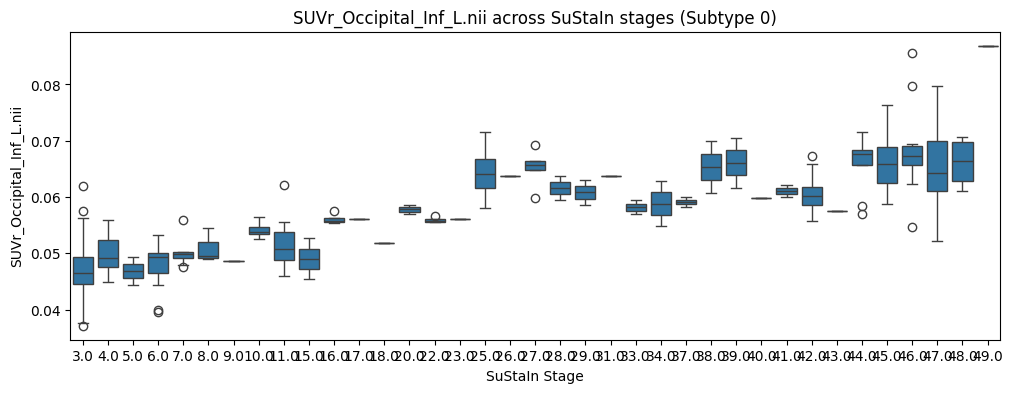

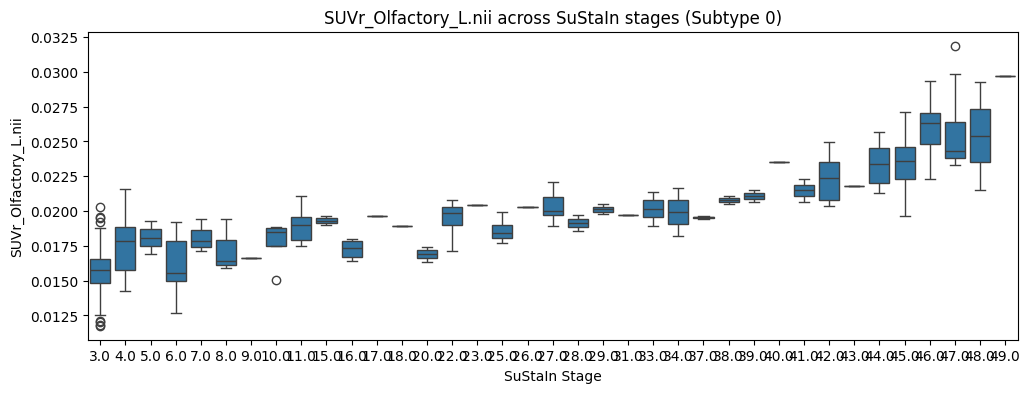

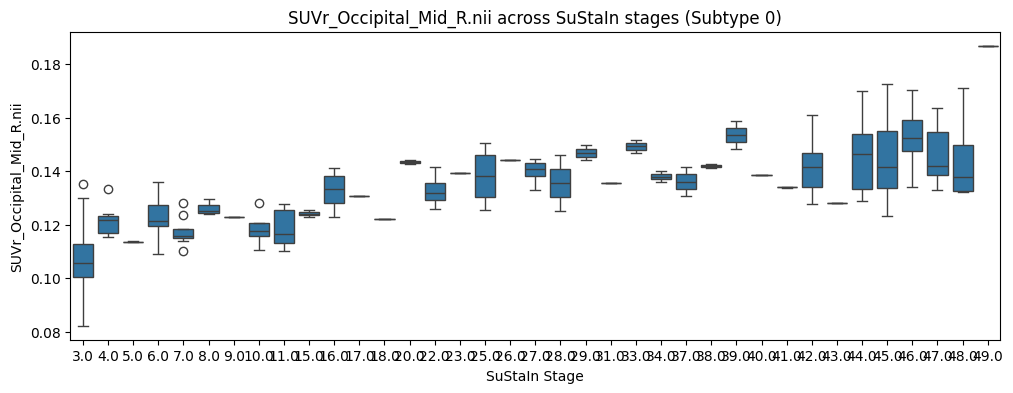

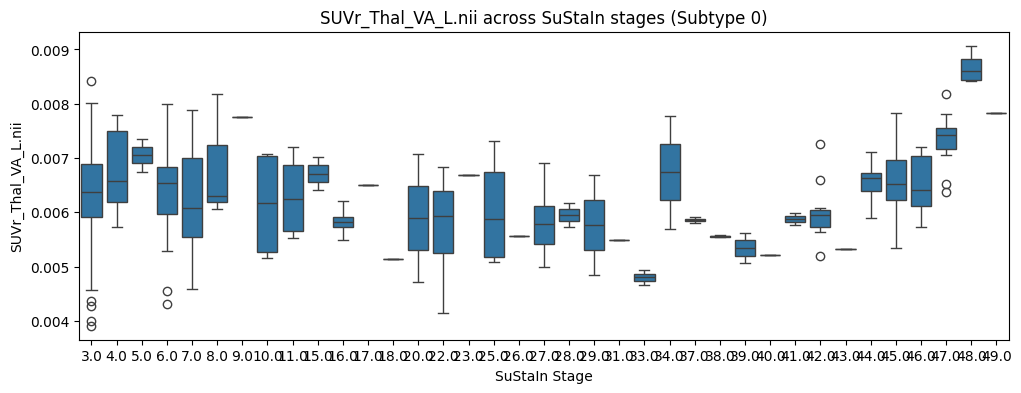

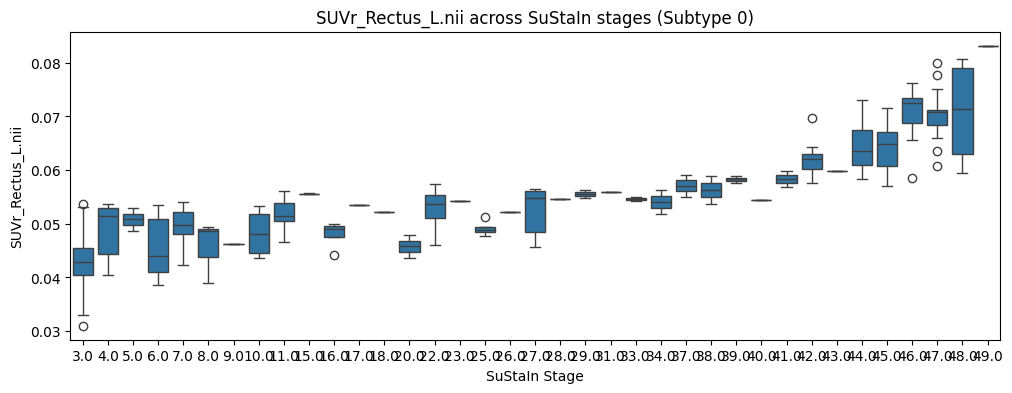

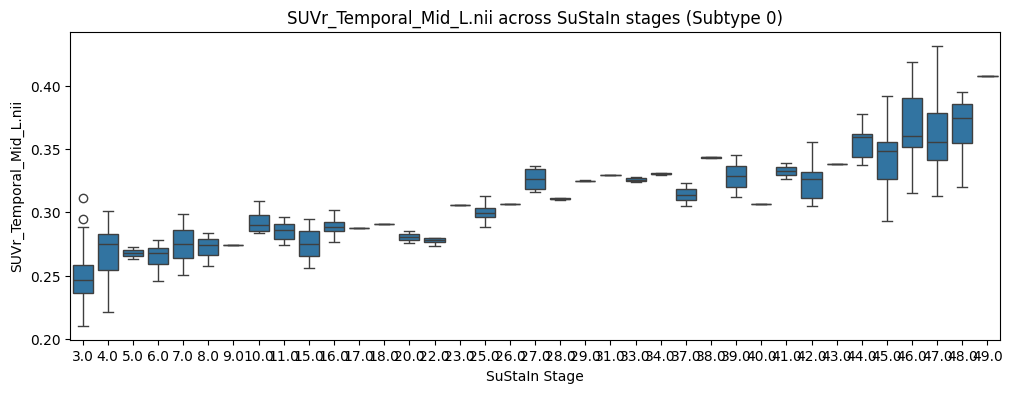

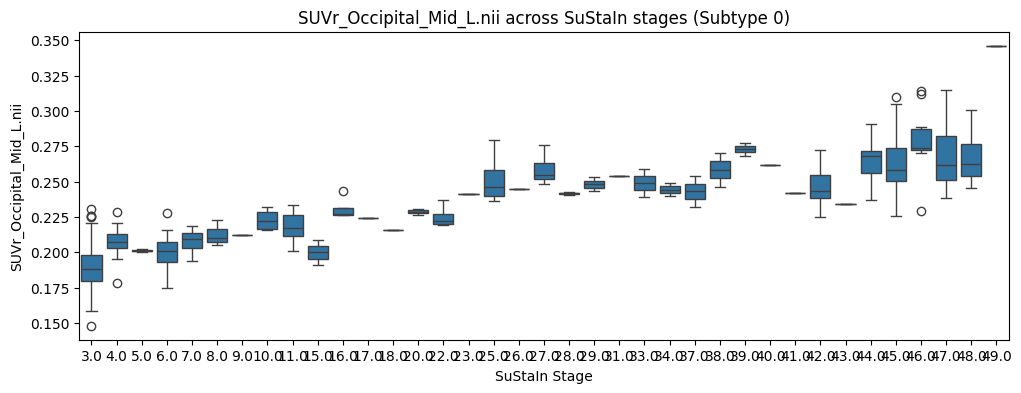

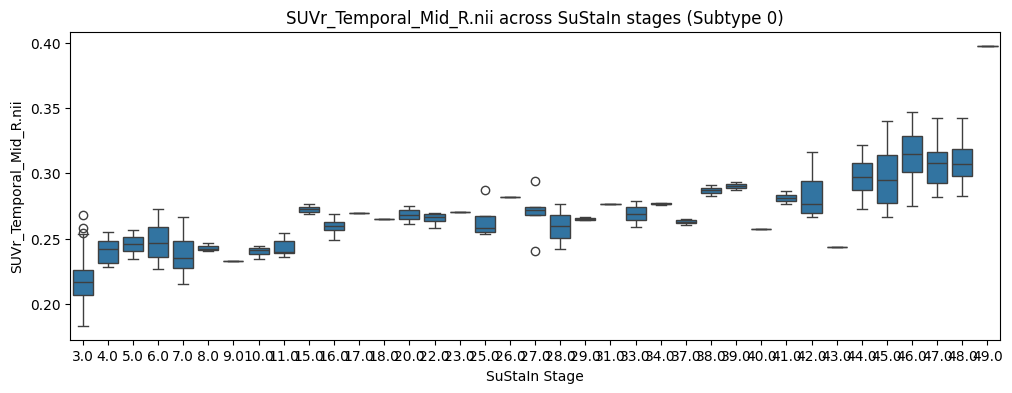

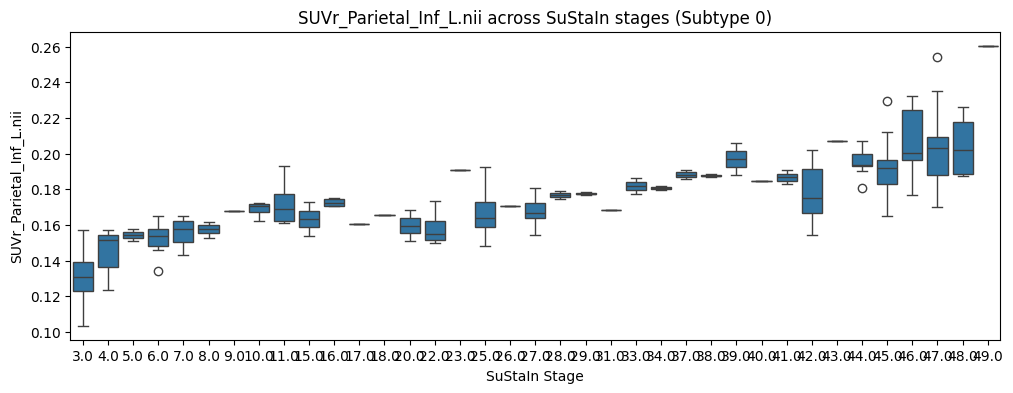

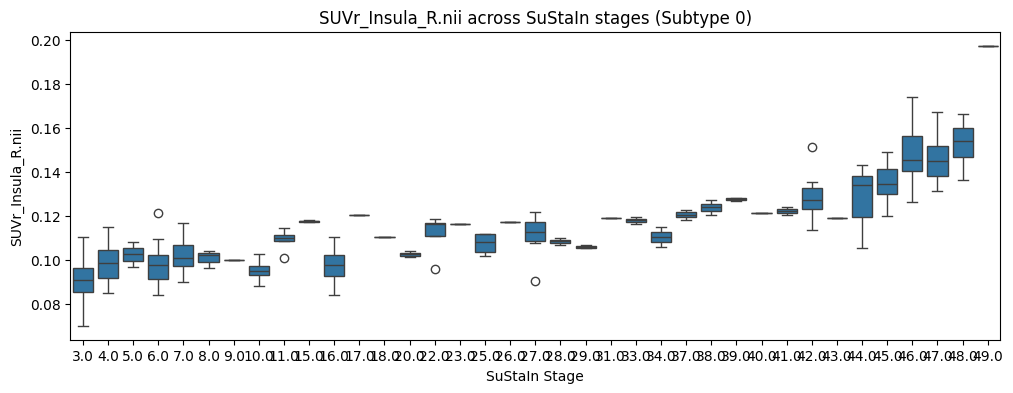

KeyboardInterrupt: 

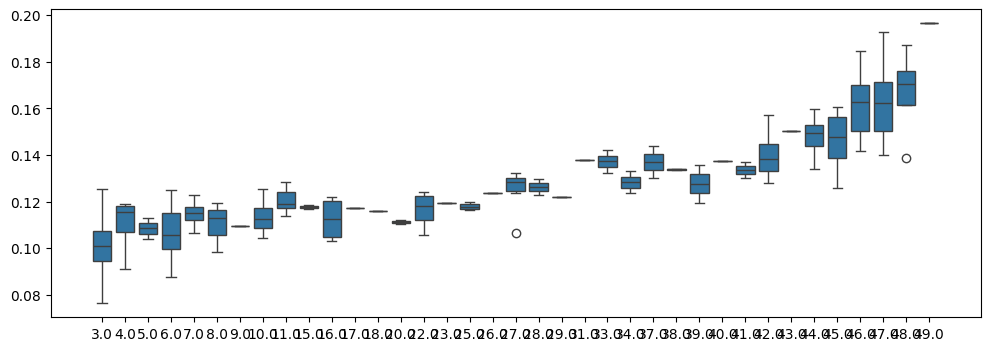

In [130]:
features_to_view = SuStaInLabels


for i in range(0,3):
    sub = zdata[zdata['ml_subtype'] == i]
    for feat in features_to_view:
        plt.figure(figsize=(12, 4))
        sns.boxplot(data=sub, x='ml_stage', y=feat)
        plt.title(f"{feat} across SuStaIn stages (Subtype {i})")
        plt.xlabel("SuStaIn Stage")
        plt.ylabel(feat)
        plt.show()